# Rapid Application Development with TraitsUI

In this tutorial, we will build on our prior lessons of image processing and classes to start to develop graphical applications in Python.  Python has several frameworks for developing graphical applications, most noteably:

     - PyQt
     - WxPython
   
Developing directly in QT or WX gives you a tremendous amount of flexibility and control over the graphical elements of the program.  However, the development cycle with these frameworks can be fairly long.  In GUI development, there's a tradeoff between framework flexibility and development cycle time.  There are other application development tools in Python that will let you design your applications faster, but sacrifice some flexibilty.  In particular, `Enthought` has developed a very nice solution to rapid graphical application design through their collection of libraries known as the `Enthought Tool Suite`.  These include:

    - Traits 
    - TraitsUI
    - Chaco
    - Mayavi
    - Enaml
    - And others.
    
We will focus on `Traits` and `TraitsUI`, although, `TraitsUI` has been unofficially supplanted by `Enaml`.  While we won't touch on `Enaml` in this tutorial, users should consider using it in place of `TraitsUI`.  For a really nice overview of using Traits and TraitsUI, [Check out this guide by Gael Varoquax](http://code.enthought.com/projects/traits/docs/html/tutorials/traits_ui_scientific_app.html).  

### Dependencies

Before getting started, you will need the following library packages (available through Canopy Package Manager if not pre-installed already)

     - traits (current version 4.5)
     - traitsui (current version 4.4)
     - scikits-image
   

And their corresponding dependencies

### What is the distinction between an application and a pure python program?  When do I want to use them?

Strangely enough, I made a screencast about application programing in python a couple years ago.  It will explain the difference between so-called "imperative programming" vs. "graphical programming".  Check it out:

In [1]:
from IPython.lib.display import YouTubeVideo

YouTubeVideo('ohHoU4qvsNs') 

The key aspects of an application are a graphical user interface (`GUI`) and `event handlers`. Event handlers are like pipelines: when an event is triggered (e.g. the `radius` of a circle class is changed), other variables must be handled (e.g. the `area` should also be updated).  In building an interactive application, the complexity of events grows quickly.  Furthermore, the event handlers must sync up to the graphical user interface.  Therefore, the major hurdles with building graphical applications come down to these issues:

   - Building complex event handlers is messy.
   - Graphical User Interface must trigger events properly.
   


### Traits and TraitsUI to the rescue

To build applications with complex event handlers, we'll use the `traits` and `traitsui` libraries.


`traits` is a Python library that implements very straightforward event handling.  `traitsui` will build a graphical user interface from the `traits` code.  


Let's revisit the Circle class from your homework.  Instead of a standard python object, let's make this a `traits` object by inheriting from the `HasTraits` parent class.  For now, forget about `area` and only focus on the `radius` attribute.

In [2]:
from traits.api import HasTraits, Float

class Circle(HasTraits): 
    
    # We no longer use __init__ to define our variables.  Any variable that
    # you want to be interactive, is defined like this:
    
    radius = Float(5.0)  #<-- default value
    
    def __str__(self):
        return 'Circle of radius %.2f' % (self.radius)

This code still acts like the pure Pyhthon circle code of your homework:  

In [3]:
c = Circle()
print c
c.radius = 10
print c

Circle of radius 5.00
Circle of radius 10.00


But this is not a pure `python` class.  This class inherits from `HasTraits`.  That means there's a whole bunch of hidden functionality encapsulted therein.  Furthermore, notice that we did not initialize our variables in the `__init__` method; rather, we imported trait types like `Float` to replace the standard Python `float`.  By initializing our variables with Traits like `Float`, we give the code special instructions on how the eventual GUI should look.  We'll get more into the GUI later, for now, let's define some event handlers.  


We can define an event handler that triggers when the radius changes through a special method of the form `_<variable>_changed()`.  **The syntax must be `_X_changed`, where x is the variable we are trying to handle; otherwise, the event handler will not work!**  Let's print a special message when the radius is changed.

In [4]:
from traits.api import HasTraits, Float

class Circle(HasTraits):     
    radius = Float(5.0) 
    
    # Event handler to notify you when something changes
    def _radius_changed(self):
        print 'NEW RADIUS IS', self.radius
    
    def __str__(self):
        return 'Circle of radius %.2f' % (self.radius)

This message should print anytime the radius is changed:

In [5]:
c = Circle()
c.radius=5
print c
c.radius=10
c.radius=20

Circle of radius 5.00
NEW RADIUS IS 10.0
NEW RADIUS IS 20.0


Simply by sticking to the `_trait_changed()` syntax, making events is this easy!  How does this magic happen?  It's cleverly encapsulated in two places:

   1.  The `HasTraits` parent class that you're inheriting from is reading through its own methods and looking for special syntax, like `_trait_changed` or `_trait_default` or a variety of other special methods for event triggering. 
    
   2.  Radius is not a normal python `float` type, it's a `Float` trait.  While the distinction may seem trivial, the `Float` trait is doing a lot under the hood.  A key difference is in how we initialized it for example...
    
    
**For every Python type (float, str, list) there's a corresponding trait (Float, Str, List)**.  Each trait will appear differently in the GUI, but will operate in the code as if it was just a standard Python type.


Below, I've added the `area` attribute to the Circle.  By using event handlers, the Circle recomputes its area anytime the radius is changed, and recomputes the radius anytime the area is changed.

In [6]:
import math
from traits.api import HasTraits, Float, Property

class Circle(HasTraits):     
    radius = Float(5.0) 
    area = Float(math.pi * 5.0**2) #<-- Initialized to area of a circle with r=5
    
    # Event Handlers
    def _radius_changed(self):
        print 'Event: radius changed to %.2f' % self.radius
        self.area = math.pi * self.radius**2
        
    def _area_changed(self):
        print 'Event: area changed to %.2f' % self.area
        self.radius = math.sqrt(self.area / math.pi)
    
    def __str__(self):
        return 'Circle of radius %.2f and area %.2f' % (self.radius, self.area)

In [7]:
c = Circle()
print c ,'\n'

c.radius = 10
print c,'\n'

c.area = 15
print c,'\n'

Circle of radius 5.00 and area 78.54 

Event: radius changed to 10.00
Event: area changed to 314.16
Circle of radius 10.00 and area 314.16 

Event: area changed to 15.00
Event: radius changed to 2.19
Event: area changed to 15.00
Circle of radius 2.19 and area 15.00 



Through a few syntax/design changes `HasTraits, float-->Float`, we now have access to a rich event handler system.  But this isn't all.  Through `TraitsUI`, you can convert this to a graphical application immediately!  Just call the `configure_traits()` method on your object, and you should get an interactive GUI that looks like the image below (ignore the code, this is just bring up the image):

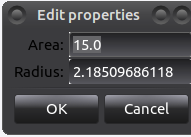

In [9]:
from IPython.display import Image
Image(filename='ss1.png')

Now to see it for yourself run the below code in your notebook. The UI will look different depending on your operating system and theme.  **This is fully interactive based on the event triggers/properties you'd already defined!**

In [10]:
c.configure_traits();

**What's going on?**

`HasTraits` is creating a user interface from the traits you've defined, and some default settings.  It chooses a backend, either QT, WX or Pyside, depending on which you have installed and on a configuration setting.  By default, yours should be in QT.  This can be changed in Canopy's Preferance menue.


The event system is left in tact, and widgets are built for you.  When you specified a `Float` trait, that also affected which type of widget was chosen to display it on the view.  A `List` trait has a different widget.  In addition, the `Float` trait will ensure that any data passed is float-convertible. For example, if a string were entered for the radius, the area would not update, but the GUI wouln not crash either.  This is quite important, because if every bad input crashed the window, it would be tough to use it!



### Customizing the View 

`TraitsUI` built the `View` for us, but we can still customize it in many ways.  For example, what if we wanted the `area` and `radius` traits to be horizontally aligned?  What if we wanted `area` to be read-only?  And what if we want the window to be resizable?  We can customize the layout in the `traits_view` attribute of any `HasTraits` subclass. We can import the relevant View objects from `traitsui`:

In [11]:
from traits.api import HasTraits, Float, Property
from traitsui.api import View, Item, HGroup, UndoButton, OKButton
import math

class Circle(HasTraits):     
    radius = Float(5.0) 
    area = Float(math.pi * 5.0**2) #<-- Initialize to pi*r**2
    
    # Event Handlers
    def _radius_changed(self):
        print 'Event: radius changed to %.2f' % self.radius
        self.area = math.pi * self.radius**2
        
    def _area_changed(self):
        print 'Event: area changed to %.2f' % self.area
        self.radius = math.sqrt(self.area / math.pi)
    
    def __str__(self):
        return 'Circle of radius %.2f and area %.2f' % (self.radius, self.area)
    
    # CUSTOMIZE THE VIEW
    traits_view = View(
                    HGroup(
                        Item('radius'),
                        Item('area',
                             # Item Options
                             style='readonly',
                             show_label=False),

                        # Group options
                        #label='Group label',
                        #layout = 'tabbed',
                        ),

                    # View options
                    resizable = True,
                    title = 'My First GUI',
                    # Manually set default size
                    #width = 400, 
                    #height = 100,
                    buttons = [UndoButton,OKButton],
                    )

In [12]:
c=Circle(radius=10)
c.configure_traits();

Event: radius changed to 10.00
Event: area changed to 314.16


Running the above code should popup something like:

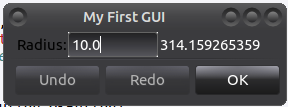

In [16]:
Image(filename='ss2.png')

The layout is a strict heirarchy of `TraitsUI` objects: `View, Group, Item`.  The outer-most object is the `View`, with options to control the window size, add buttons, the window name etc. The `Group` (or `HGroup`, `VGroup` for horizontal and vertical groups) has several traits.  For example putting three traits together in a horizontal bundle as we did here.  Group options include a group label, and the ability to layout groups in tabbed windows.  We will get more into group options later.  The `Item` object defines the layout of a single trait/widget.  The Item must be called with the name of the trait as a string followed by options, eg

    Item('area', style='readonly', show_label=False)
    
In this case, the users are prevented from editing the area, and the "Area" label is hidden.  
This is just scratching the surface, and you should check out the [TraitsUI User Manual](https://traitsui.readthedocs.org/en/latest/) for more information.

### Other Trait Types and More View Options

We'll check out some other useful traits, as well as different Item style options in the View for:

    - String 
    - Range : A fixed ranged of values.
    - File : Path to a file.
    - List : List of python items
    - Instance : An instance of another HasTraits class.
    
`Instance` is a placeholder for a `HasTraits` class.  For example, we can embed our entire `Circle` into the new `Demo` object.  In addition, this will illustrate how to make groups of tabs and the difference between using the default `Item` style (which is 'simple') and the 'custom' Item style, which usually presents a more elaborate widget to the trait.  This will make more sense when you try the example:

In [17]:
from traits.api import HasTraits, Range, List, File, Instance, String, Color
from traitsui.api import View, Item, Group, VGroup, ListEditor

class Demo(HasTraits):     
    """ Show off various traits and view options.
    """
    foo_color = Color()
    foo_string = String('Edit me')
    foo_range = Range(0,100)
    foo_list = List(['A','B','C'])
    foo_file = File()
    foo_circle = Instance(Circle)
    
    def _foo_circle_default(self):
        """ Provide a default value for the Circle instance."""
        return Circle(radius = 5)  
    
    # CUSTOMIZE THE VIEW
    traits_view = \
              View(
                    # Vertical group all items using the "custom" Item option
                Group(
                    VGroup( 
                        Item('foo_string'),
                        Item('foo_range'),
                        Item('foo_color', label='Color (click to edit)'),
                        Item('foo_list'),
                        Item('foo_file', label='select file'),
                        Item('foo_circle', show_label=False),
                        label='SIMPLE'
                        ),

                   # VGroup of file and Circle with CUSTOM STYLE 
                    VGroup(
                        Item('foo_string', style='custom'),
                        Item('foo_list'),
                        Item('foo_color', style='custom'),
                        Item('foo_file',  style='custom'),
                        Item('foo_circle',  style='custom'),
                        label='CUSTOM'
                        ),        

                 # Group option to layout the subgroups as tabs
                 layout='tabbed'),

              # View options
              resizable = True,
              width=500,
              height=400,
              title = 'Demo',
              )

In [18]:
Demo().configure_traits();

Here is what my GUI looks like for the `SIMPLE` tab:

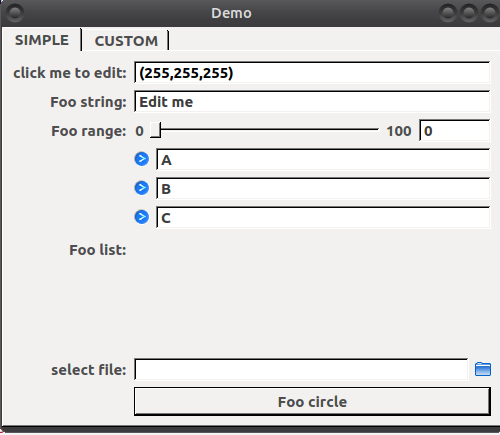

In [21]:
Image(filename='ss3.png')

And for the `CUSTOM` tab:

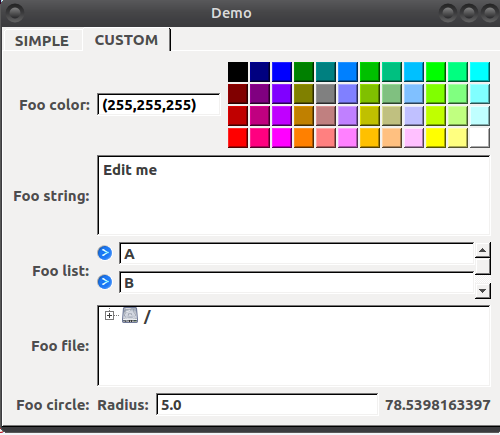

In [22]:
Image(filename='ss4.png')


The different `styles` will envoke different "trait editors".  An editor is a graphical element that sets a trait value.  For example, the `foo_file` trait is using a fairly complex `file editor` that let's the user choose a file.  Once chosen, that file is then stored in the variable `self.foo_file`.  The `color` trait envokes a helpful `color_editor`, without requiring any work on your part.  Editors are a big reason that building applications with `Traits/TraitsUI` is so quick.  Editors can get quite complex, leading to graphical interfaces with much sophistication.  See the links below for examples of the `predefined Traits Editors`:

   - [Basic Editors](http://code.enthought.com/projects/traits/docs/html/TUIUG/factories_basic.html)
   - [Advanced Editors](http://code.enthought.com/projects/traits/docs/html/TUIUG/factories_advanced_extra.html)

### The Mona Lisa

Da Vinci's famous Mona Lisa is possibly the most recognizable painting in the world.  In 2012, the Prado museum [debuted a copy of the Mona Lisa](http://www.cnn.com/2012/02/21/world/europe/spain-mona-lisa/) that has been restored to give a show what the Mona Lisa might have looked like when it was originally painted.  Furthermore, unlike other copies of the Mona Lisa that were created long after the original, the Prado is believed to have been painted at the same time by a pupil sitting right next to Da Vinci.  Because of small changes in line of site, some have even as gone to hypothesize that the Mona Lisa and Mona Lisa Prado form a pair of images that might be the first attempt at producing a [3D Image](http://hyperallergic.com/124289/was-the-mona-lisa-the-worlds-first-3d-image/).

<br>

This project is bundled with two images of the Mona Lisa:

   - **mona.jpg** : the original Mona Lisa
   - **prado.jpg** : the Prado Mona Lisa
    
<br>
    
These images are shown below.  While we could use the notebook's `Image()` display function, let's use matplotlib `imshow()` to plot the images side by side.  The `%pylab inline` call will import matplotlib, and several other useful scientific analysis tools into the notebook namespace, so we don't have to import `matplotlib` directly.

/home/glue/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['axes', 'f', 'Button']
`%matplotlib` prevents importing * from pylab and numpy


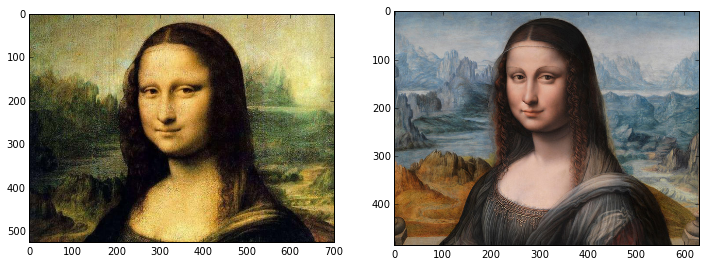

In [106]:
%pylab inline
import skimage.io as skio

# Make a matplotlib figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))

# Read images into scikit-image so we can plot and manipulate them
mona = skio.imread('mona.jpg')
prado = skio.imread('prado.jpg')

ax1.imshow(mona) 
ax2.imshow(prado);

**We're going to use Mona Lisa as the motivation to build an image processing GUI**.  By combining our `TraitsUI` and `scikit-image` skills, in princple, we should be able to manipulate this image in an interactive graphical application, rather than through just the scikit-image API of commands.  

### First Steps: reading in images

Even with the simplicity of TraitsUI, this can get fairly involved.  Therefore, let's go through the process in a few steps, and then your focus will be to extend the program's functionality.  

<br>

Before we do anything cool, we have to bring in an image and display it on the GUI.  Here is a complete working example:

In [50]:
from __future__ import division

from traits.api import HasTraits, File, Array
from traitsui.api import View, Item
from chaco.api import ArrayPlotData, Plot
from enable.api import ComponentEditor
import numpy as np 


def flip180(array):
    """ Flip array 180 degrees and then reflect horizontally.  This will ensure
    chaco plots align image properly as matplotlib.imshow() does
    """
    return np.fliplr(np.rot90(np.rot90(array)))
    

class ImageViewer(HasTraits):
    """ Viewer Class to compare two images.  Each image is an instance of chaco
    ImagePlot.  Just a skeleton example for now.
    """
    
    # Traits
    path = File('prado.jpg') #Default to empty, will be set in set_defaults() below

    # Image stored in numpy arrays via scikit-image
    # image_data trait monitor it for changes and triggers events
    image = Array    

    # Actual plot objects
    plot1 = Instance(Plot)
    
    # Plot data is associated with a plot, so changes in data will trigger plot redraws
    plot1_data = ArrayPlotData
    
    # Define layout of User Interface
    traits_view = View(
             Item('path', label='Image Path'),
             Item('plot1', show_label=False, editor=ComponentEditor() ),
          width=700,
          height=500,
          resizable=True, 
          title="GWU Image Comparison Tool",
       )
    
    def __init__(self, *args, **kwargs):
        # Super intializes all traits from HasTraits class
        super(ImageViewer, self).__init__(*args, **kwargs)
                
        # Create two plots, and set plotdata traits
        self.plot1_data = ArrayPlotData(imagedata = flip180(self.image))
        self.plot1 = Plot(self.plot1_data)
        self.plot1.img_plot("imagedata")
                 
    
    # Default values for image and image_modified (set to same default image)
    def _image_default(self):
        return skio.imread(self.path)

    def _image_changed(self):
        """ If primary image changes (ie user selects new image...)"""
        # Should inspect that isn't gray image
        self.plot1_data.set_data('imagedata', flip180(self.image))
    
    # Event Handlers (must conform to _x_changed() syntax 
    # --------------
    def _path_changed(self):
        """ Change file path, reset both images, reset all slider defaults."""
        self.image = skio.imread(self.path)        

In [52]:
ImageViewer().configure_traits();

When you run this example, do you get something like the screenshot below?  Click the little folder icon and you should be able to change the selected image.  It should import any image, although I've only tested it on .jpg and .png images. 

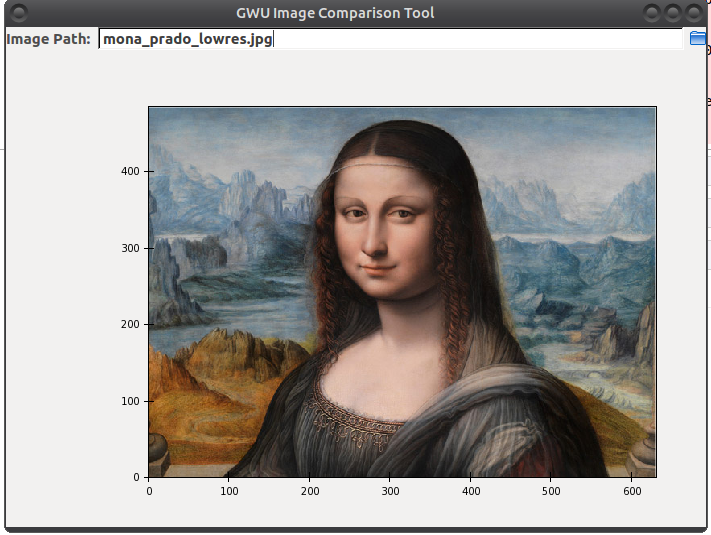

In [43]:
Image('ss5.png')

While it may look daunting at first, let's try to understand this example.  You'll be surprised by how much you already know:

<br>

First, what Traits were defined?  The two important traits are `path` and `image`.  The path stores a filename, and it's really easy to implement because TraitsUI comes packaged with a `File` trait.  That's how the GUI knew to launch a file browser when that little folder icon was clicked; it's all encapsulated in `File` and `HasTraits`.  We merely defined the `file` trait type, and everything *just worked*.

<br>

The `image` trait is a bit tricky.  That's because there is no such thing as an image trait.  The closest thing to an Image Trait, as far as TraitsUI is concerned, is a 2D `Array` trait.  What we're doing is storing a 2D array, and plotting it.  **Plotting within a TraitsUI window is done through the `chaco` library.**  In other words, TraitsUI doesn't understand images or matplotlib plots.  TraitsUI understands 2DArrays and Chaco plots.  All of the hoopla in my code is merely to store an image with scikit-image, but actually us it as a 2DArray trait in a manner compatible for `chaco`, which actually displays it as a 2dplot.  That's why I had to envoke some of these abstract containers like `ArrayPlotData` and `ComponentEditor`.  **All that you need to know is that the image can be manipulated using scikit-image functions directly, and the plotting should just work.**

<br>

Did you notice the `flip180` function?  This rotates an array 180 degrees.  Why is this useful?  It turns out that when matplotlib plots an image, it actually is flipping it by 180 degrees to present an upright image.  Chaco doesn't do this by default, so if you remove the flip180 call, you should get an upsidedown image!

### Manipulating Mona

I went ahead and extended the example to store two images side by side.  The idea being that we can keep an unmolested copy of the image on the left-hand side of the view, and then manipulate the image on the right.  Something like this:

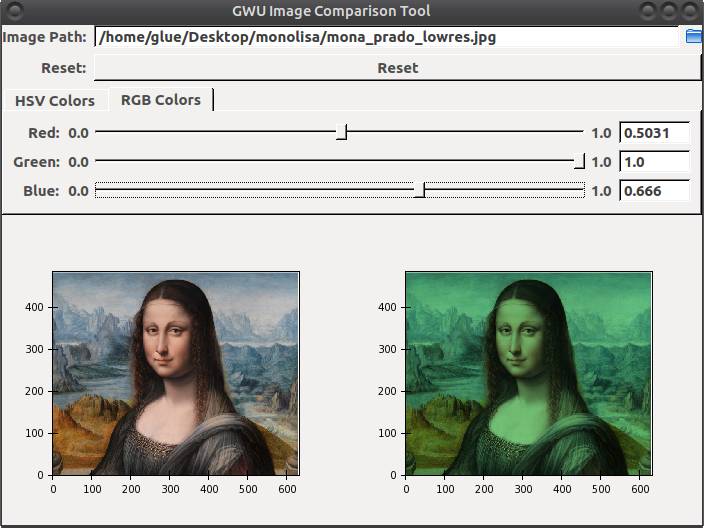

In [53]:
Image('ss6.png')

This new GUI let's you play with the colorspace of the image.  The original image is represented in [RGB colorspace](http://en.wikipedia.org/wiki/RGB_color_space), where each pixel in the image is stored as an RGB value.  For example, a red pixel would have a value of (1,0,0).  A blue pixel would have a value of (0,0,1) and a green of (0,1,0).  A white pixel is actually (1,1,1) and black pixel is (0,0,0).  A gray pixel would be something like (0.5, 0.5, 0.5).

<br>

What we're doing in the GUI is letting you scale the intensity of the RGB channels.  So for example, setting the "red" slider bar to 0 would remove all red value from the image.  This result in a mostly blue and green image.  Removing some blue accentuates the green.

<br>

This is actually pretty easy to do in scikit-image, because images are just numpy arrays.  Therefore, we can multiply them by red, green and blue masks.  For example:

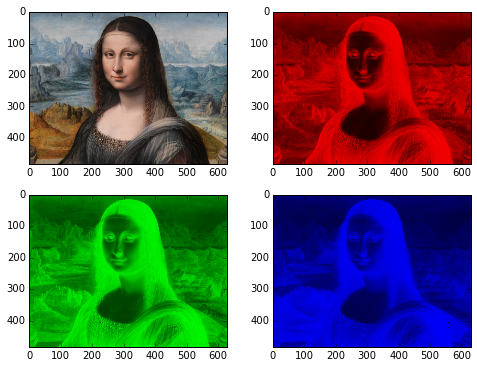

In [83]:
# Multiply prado image (which is a 2d numpy array) by color masks
red =   prado  * (1, 0, 0)
green = prado  * (0, 1, 0)
blue =  prado  * (0, 0, 1)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,6))

ax1.imshow(prado)
ax2.imshow(red)
ax3.imshow(green)
ax4.imshow(blue);

The GUI is doing this, where the float values of the red, green and blue channels are `range` traits.  A code snippet that might represent this behavior in a `HasTraits` object looks like this:

In [86]:
class ImageViewer(HasTraits):
    """ """
    red = Range(0.0, 1.0, value=1.0)
    green = Range(0.0, 1.0, value=1.0)
    blue = Range(0.0, 1.0, value=1.0)   

    @on_trait_change('red, green, blue')  #<-- decorator assigns same event to multiple traits 
    def colorize(self):
        """ Add color of the given hue to an RGB image.
    
        By default, set the saturation to 1 so that the colors pop!
        """     
        rgb_multiplier = [self.red, self.green, self.blue]        

        # Scale by RGB values
        self.image_modified = self.image * rgb_multiplier   

Where `self.image_modified` is the right image on the GUI.  The GUI is setup to redraw itself anytime `image_modified` is called.  

### HSV Colors

If it's hard for you to think of the rich color diversity in the Mona Lisa as a sum of red, green and blue colors, you're not alone.  Our brains aren't designed to think in RGB color.  It would be better to work in a more human-friendly colorspace, [Hue-Saturation-Value (HSV)](http://en.wikipedia.org/wiki/HSL_and_HSV).  Any RGB color can be mapped to HSV and vice versa; in fact the mapping is one-to-one.

<br>

Instead of red, green, blue channels, HSV decomposes an image into orthogonal hue, saturation and value channels:

   - **hue** : Refers to the color distribution in the image.  
   - **saturation** : How vivid are the colors (0=gray image)
   - **value**: How bright is the image?

<br>

By the way, if you're mathematically-inclined, you'll probably find it fascinating that RGB and HSV are orthonormal vector spaces, and if you think about RGB as cartesian coordinates, eg XYZ, then HSV would be cylindrical coordinates.  In other words, the mapping from cartesian coordinates to cylindrical coordinates in 3D space is the same as the mapping from RGB to HSV in color space.

<br>

The wikipedia image is cool enough to warrant a link:

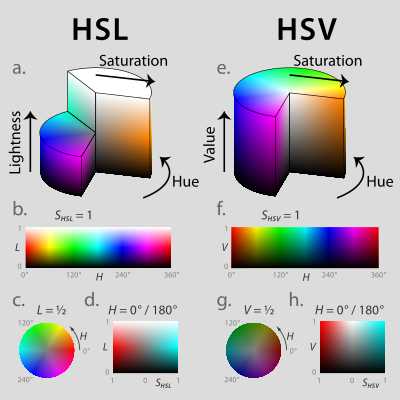

In [85]:
Image('http://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Hsl-hsv_models.svg/400px-Hsl-hsv_models.svg.png')

Scikit-image makes it particularly easy to transform an image between color spaces.  The idea is that we would transform from RGB2HSV, change the HSV values, and then back-transform to RGB.  For example, let's transform to HSV, scale the hue, saturation and value by 50%, and then transform back, similar to what we did before:

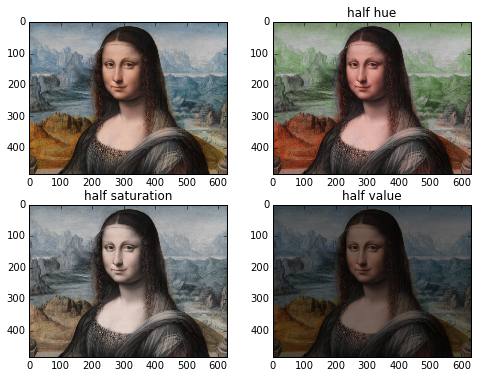

In [103]:
# Import the transformations
from skimage.color import rgb2hsv, hsv2rgb
from skimage import img_as_ubyte

hsv_prado = rgb2hsv(prado)

hue   = hsv_prado * (0.5, 1, 1)
sat   = hsv_prado * (1, 0.5, 1)
value = hsv_prado * (1, 1, 0.5)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,6))

# Before we plot, we need to transform back into rgb space, as matplotlib expects RGB colors.
ax1.imshow(prado);
ax2.imshow(hsv2rgb(hue))
ax3.imshow(hsv2rgb(sat))
ax4.imshow(hsv2rgb(value))

ax2.set_title('half hue')
ax3.set_title('half saturation')
ax4.set_title('half value');

If you understand scikit-image and TraitsUI, you have a lot of power at your disposal to make cool image processing GUIs.  

<br>

**Without further ado, here is the final code for the viewer:**

In [110]:
from __future__ import division

from traits.api import HasTraits, File, Instance, Enum, Array, Property, Range, \
     Button, on_trait_change
from traitsui.api import View, Item, HGroup, VGroup, Group
from chaco.api import ArrayPlotData, Plot
from enable.api import ComponentEditor
import numpy as np 

# Scikit-image imports
import skimage.io as skio
import skimage.color as skcolor
from skimage import img_as_ubyte #Change image data from float to int

def flip180(array):
    """ Flip array 180 degrees and then reflect horizontally.  This will ensure
    chaco plots align image properly as matplotlib.imshow() does
    """
    return np.fliplr(np.rot90(np.rot90(array)))
    

class ImageViewer(HasTraits):
    """ Viewer Class to compare two images.  Each image is an instance of chaco
    ImagePlot.
    """
    
    # Traits
    path = File('prado.jpg') #Default to empty, will be set in set_defaults() below
    colorspace = Enum('rgb', 'hsv')

    # Image stored in numpy arrays via scikit-image
    # image_data trait monitor it for changes and triggers events
    image = Array    
    image_modified = Array

    # Actual plot objects
    plot1 = Instance(Plot)
    plot2 = Instance(Plot)
    
    # Plot data is associated with a plot, so changes in data will trigger plot redraws
    plot1_data = ArrayPlotData
    plot2_data = ArrayPlotData
    
    # Color traits (these are actually scale factors, so 1 means full hue, 0 means no hue)
    hue = Range(0.0, 1.0, value=1.0)
    sat = Range(0.0, 1.0, value=1.0)
    value = Range(0.0, 1.0, value=1.0)
    
    red = Range(0.0, 1.0, value=1.0)
    green = Range(0.0, 1.0, value=1.0)
    blue = Range(0.0, 1.0, value=1.0)    

    reset = Button    
    
    # Define layout of User Interface
    traits_view = View(
             Item('path', label='Image Path'),
             Item('reset'),
             Group(
                 VGroup(
                      Item('hue'),
                      Item('sat', label='Saturation'),
                      Item('value'),
                  label='HSV Colors'
                     ),
                  VGroup(            
                      Item('red'),
                      Item('green'),
                      Item('blue'),
                  label='RGB Colors'),
             layout='tabbed'),
             # Align plots horizontally and use special "componenteditor" to 
             # display them correctly
             HGroup(
                 Item('plot1', show_label=False, editor=ComponentEditor() ),
                 Item('plot2', show_label=False, editor=ComponentEditor() )
             ),
          width=700,
          height=500,
          resizable=True, 
          title="GWU Image Comparison Tool",
       )
    
    def __init__(self, *args, **kwargs):
        # Super intializes all traits from HasTraits class
        super(ImageViewer, self).__init__(*args, **kwargs)
                
        # Create two plots, and set plotdata traits
        self.plot1_data = ArrayPlotData(imagedata = flip180(self.image))
        self.plot1 = Plot(self.plot1_data)
        self.plot1.img_plot("imagedata")
        
        self.plot2_data = ArrayPlotData(imagedata = flip180(self.image_modified))
        self.plot2 = Plot(self.plot2_data)
        self.plot2.img_plot("imagedata")

    #http://scikit-image.org/docs/dev/auto_examples/plot_tinting_grayscale_images.html    
    @on_trait_change('hue, sat, value, red, green, blue')
    def colorize(self):
        """ Add color of the given hue to an RGB image.
    
        By default, set the saturation to 1 so that the colors pop!
        """
     
        rgb_multiplier = [self.red, self.green, self.blue]
        hsv_multiplier = [self.hue, self.sat, self.value]
        
        # Scale by RGB values
        image_mod = self.image * rgb_multiplier       
        
        # Transform to HSV space
        image_mod = skcolor.rgb2hsv(image_mod) 
        
        # Scale by HSV values, scale, convert back to RGB
        image_mod = image_mod * hsv_multiplier
        image_mod  = skcolor.hsv2rgb(image_mod)
               
        # Conversions changed data from ints (0,1...255)
        # to floats (0, 0.1 ... 1.0)
        # This converts back to ints and scale up to 255
        # Matplotlib isn't affected by this, but chaco is
        image_mod = img_as_ubyte(image_mod / 255.0 )        
        

        # Trigger update 
        self.image_modified = image_mod
                    
       
    def _reset_fired(self):
        for trait in ['hue', 'sat', 'value', 'red', 'green', 'blue']:
            setattr(self, trait, 1.0)        
    
    # Default values for image and image_modified (set to same default image)
    def _image_default(self):
        return skio.imread(self.path)
    
    def _image_modified_default(self):
        return self.image  # Already flipped 
    
    def _image_changed(self):
        """ If primary image changes (ie user selects new image...)"""
        # Should inspect that isn't gray image
        self._reset_fired() #<-- reset sliders
        self.plot1_data.set_data('imagedata', flip180(self.image))
        self.image_modified = self.image
        
    def _image_modified_changed(self):
        self.plot2_data.set_data('imagedata', flip180(self.image_modified))
    
        
    # Event Handlers (must conform to _x_changed() syntax 
    # --------------
    def _path_changed(self):
        """ Change file path, reset both images, reset all slider defaults."""
        self.image = skio.imread(self.path)     

In [115]:
ImageViewer().configure_traits();

By munging with the HSV and RGB colors, one can kind of start to see how the color deterioration over time caused the Mona Lisa to look like it is today.  Of course the chemical processes involved in image deterioration are not simply mappings from RGB to HSV colorspace, but isn't it interesting how otherwise seemingly unreleated colors are mapped to one another through these transformations?

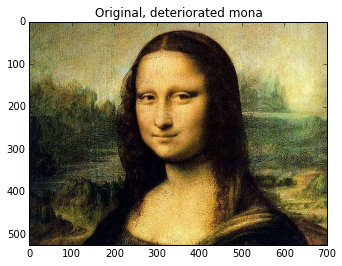

In [114]:
imshow(mona)
plt.title('Original, deteriorated mona');

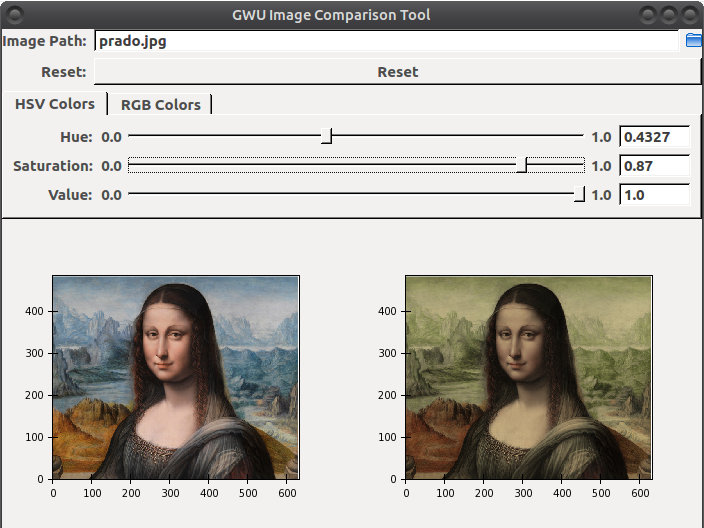

In [117]:
Image('ss8.png')

I acheived this with the settings:
    
    HSV = (0.433, 0.87, 1.0)
    RGB = (0.697, 1.0, 0.65)
    
PS, the `reset` button will reset all sliders.

### Assignments: Extending the GUI

Your project will be to add some more functionality to the GUI.  We provide 3 suggested assignments, but checkout the the [scikit-image examples](http://scikit-image.org/docs/dev/auto_examples/) and if you are inspired by a really cool feature, add that to the GUI instead!  You won't be penalized for taking the initiative. **Otherwise, choose from one of the three following possibilities:**

`Option 1: IMAGE THRESHOLDING`

As we saw in the worldmap example, the easiest way to segment an image is to convert it to 1-channel (eg gray scale) and retain all pixels greater than some cutoff value.  We can do this in the monalisa as well by first converting the RGB to gray, and then retaining all values above a certain threshold.  For example:

Gray min 0.019 and max 0.819


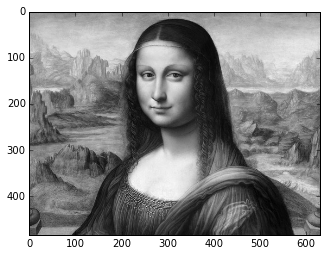

In [136]:
from skimage.color import rgb2gray
gray_prado = rgb2gray(prado)

print 'Gray min %.3f and max %.3f' % (gray_prado.min(), gray_prado.max())

# Specify colormap=gray or false colors will be assigned
imshow(gray_prado, cmap='gray');

Notice that the transformation to gray is now limited between values of 0 and 1.  Therefore, a threshold should filter between 0 and 1:

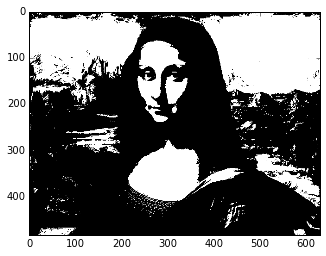

In [139]:
thresholded = gray_prado > 0.5

imshow(thresholded, cmap='gray');

Your assignment is to add a 3rd panel to the GUI called `Thresholding`.  In this panel should be a range slider from 0 to 1.  Hook an event up so that when the user slides the slider, the right hand image in the GUI displays the thresholded image. 

`Option 2: LUV colorspace`

The [LUV/YUV Colorspace](http://en.wikipedia.org/wiki/YUV) is yet another way orthonormal colorspace often used by researchers.  It is implemented in scikitimage through `rgb2luv` in an identical manner as we saw with `rgb2hsv`.  Your assignment is to add this third colorspace a new tab, `LUV colors` with three sliders for the luminance, U-chrominance, and V-chrominance channels.

`Option 3:` Edge Detection

In image processing, edge-detection is a very common task.  Edges in an image are regions where the pixels change abruptly.  If you think of the pixles in the image as a 2D function, where each value is the brightness of the pixel, then the edges correspond to the gradient (spatial derivative) of the image.  The derivative of the image will highlight regions of strong change.  

<br>

There are several ways to compute the gradient of a 2D image, and without getting into details, it's sufficient to realize that each way will give a slightly different value of the gradient.  Two popular ways to take the first derivative of the image are the [roberts](http://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=sobel#skimage.filters.roberts_pos_diag) and [sobel](http://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=sobel#skimage.filters.sobel) operator.  **Like with thresholding, we'll need to first down-convert our 3-channel RGB colored image into a 1-channel gray image for the Sobel operator to work.**



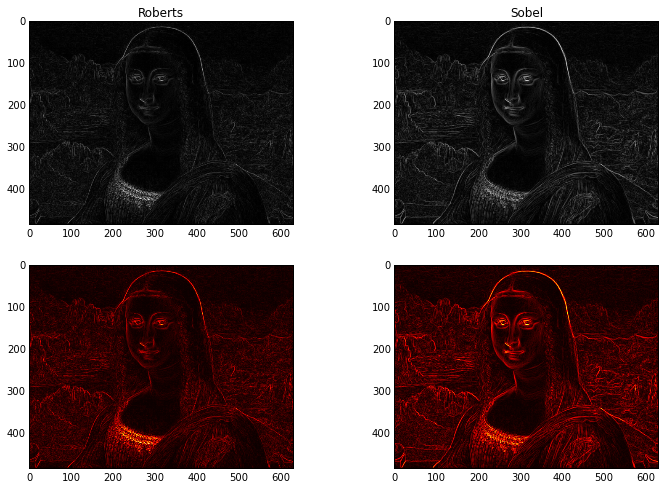

In [171]:
#from skimage.feature import sobel, roberts_pos_diag  #<--- In new versions of scikit-image, may need to do this instead
from skimage.filter import sobel, roberts    #<--- I'm using v0.10.1 

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))

rob_prado = roberts(gray_prado)
sob_prado = sobel(gray_prado)

# Let's plot in gray, and also in false color using "hot" colormap
ax1.imshow(rob_prado, cmap='gray')
ax2.imshow(sob_prado, cmap='gray')
ax3.imshow(rob_prado, cmap='hot')
ax4.imshow(sob_prado, cmap='hot')
ax1.set_title('Roberts')
ax2.set_title('Sobel');

The gradient paints edges based on the magntidue of the derivative, so stronger edges are brighter.  Sometimes, we just want every single edge pixel to be completely white, and non-edge pixels to be completely black!  In other words, to threshold out the edges.  Unlike the gradient operators like Sobel and Roberts, Canny will threshold the edges.  

<br>

The `Canny` filter is a powerful edge detection algorithm based on the second spatial derivative (ie the Laplacian) of the image.  The Canny filter is very popular because it's sensitive to weak edges.  There are several optional parameters to customize Canny, but let's use the defaults:

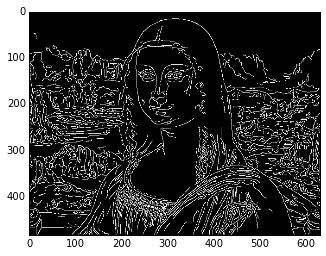

In [156]:
from skimage.filter import canny
imshow(canny(gray_prado), cmap='gray');

Your assignment is to use the `Enum` trait to create a dropdown menu on the view (make a third tab called edge detection next to the RGB colors).  The dropdown should have three two options, *sobel*, *canny*, and *roberts*. Depending on the value, an event should be triggered to find the edges, and pass the images of the edges into the right-hand image on the viewer.

<br>

Here's a quick example of the Enum trait:

In [162]:
from traits.api import Enum

class EnumTest(HasTraits):
    
    foo = Enum(['a','b','c'])
    
    def _foo_changed(self, old, new):
        print 'Changing %s to %s' %(old, new)

EnumTest().configure_traits();


Changing a to b
Changing b to c

<hr>
<br>


<div style="float:left; \">
    <img src="https://avatars0.githubusercontent.com/u/1972276?s=460" 
 align=left; text-align:center; style="float:left; margin-left: 5px; margin-top: -25px; width:150px; height:150px" /> 
</div>

<div style="float:left; \"><a href="https://github.com/hugadams">
    <img src="https://assets-cdn.github.com/images/modules/logos_page/GitHub-Mark.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>


<div style="float:left; \"><a href="https://twitter.com/hughesadam87">
    <img src="http://paymentmagnates.com/wp-content/uploads/2014/04/twitter-icon.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.researchgate.net/profile/Adam_Hughes2?ev=hdr_xprf">
    <img src="http://www.txhughes.com/images/button-researchgate.png" 
 align=left; text-align:center; style="float:left; margin-left: -175px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.linkedin.com/profile/view?id=121484744&trk=nav_responsive_tab_profile_picg">
    <img src="http://smallbusinessesdoitbetter.com/wordpress/wp-content/uploads/li.png" 
 align=left; text-align:center; style="float:left; margin-left: -75px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:center; \"><a href="http://www.gwu.edu/">
    <img src="https://raw.githubusercontent.com/hugadams/pyparty/master/pyparty/data/gwu.png" 
 align=center style="float:center; margin-right: 30px; margin-top: -35px; width:335px; height:180px" />
</div>


<h4 style="margin-top:0px;"> This notebook is free for redistribution.


<h3 style="margin-top:30px;"> Questions or Feedback? </h3>

* Adam Hughes: hughesadam87@gmail.com 
* twitter:  <a href="https://twitter.com/hughesadam87" target="_blank">@hughesadam87</a>
* <a href="http://www.gwu.edu/~condmat/CME/reeves.html" target="_blank">Mark Reeves Biophysics Group</a>


In [163]:
# Change the notebook style/layout
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())